In [10]:
import numpy as np
import pandas as pd
import torch

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm


In [19]:
class ShotMakeMLP(nn.Module):
    def __init__(self, num_shooters, embed_dim, num_numeric_feats, hidden_dims=[64,32]):
        super().__init__()
        self.embedding = nn.Embedding(num_shooters, embed_dim)
        input_dim = embed_dim + num_numeric_feats
        
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(0.2))
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))  # single output for logistic
        self.mlp = nn.Sequential(*layers)

    def forward(self, shooter_id, numeric_feats):
        x_embed = self.embedding(shooter_id)
        x = torch.cat([x_embed, numeric_feats], dim=1)
        x = self.mlp(x)
        return torch.sigmoid(x).squeeze()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ------------------------------
# 1️⃣ Define your model class
# ------------------------------
class ShotMakeMLP(nn.Module):
    def __init__(self, num_shooters, embed_dim, num_numeric_feats, hidden_dims=[64,32]):
        super().__init__()
        self.shooter_embed = nn.Embedding(num_shooters, embed_dim)
        input_dim = embed_dim + num_numeric_feats
        
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, shooter_ids, numeric_feats):
        x = self.shooter_embed(shooter_ids)
        x = torch.cat([x, numeric_feats], dim=1)
        return self.mlp(x).squeeze(1)

# ------------------------------
# 2️⃣ Load saved artifacts
# ------------------------------

# Shooter mapping
shooter2id = torch.load("shooter2id.pth")  # saved dict: {shooter_name: id}
num_shooters = len(shooter2id)

# Scaler
scaler = torch.load("scaler.pth")  # saved StandardScaler for numeric features

# Model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_numeric_feats = 6  # adjust to your feature count
model = ShotMakeMLP(num_shooters=num_shooters, embed_dim=16, num_numeric_feats=num_numeric_feats)
model.load_state_dict(torch.load("shot_mlp_weights.pth", map_location=device))
model.to(device)
model.eval()

# ------------------------------
# 3️⃣ Prepare new data
# ------------------------------
# Example new shot dataframe
new_shots = pd.DataFrame({
    "shooter": ["Sam Cassell", "Cedric Ceballos"],
    "shot_distance": [15.0, 26.0],
    "shooter_last5_fg": [0.6, 0.4],
    "is_3pt": [0,1],
    "is_layup": [0,0],
    "blocked_shot": [0,0],
    "assist_on_shot": [1,0]
})

# Shooter IDs
shooter_ids = new_shots["shooter"].map(shooter2id).fillna(0).astype(int).values
shooter_ids = torch.tensor(shooter_ids, dtype=torch.long, device=device)

# Numeric features
numeric_feats = new_shots[["shot_distance", "shooter_last5_fg", "is_3pt",
                            "is_layup", "blocked_shot", "assist_on_shot"]].values.astype(np.float32)
numeric_feats = scaler.transform(numeric_feats)
numeric_feats = torch.tensor(numeric_feats, dtype=torch.float32, device=device)

# ------------------------------
# 4️⃣ Predict
# ------------------------------
with torch.no_grad():
    proba = model(shooter_ids, numeric_feats).cpu().numpy()
    predictions = (proba >= 0.5).astype(int)

print("Predicted probabilities:", proba)
print("Predicted classes:", predictions)


In [20]:
model = ShotMakeMLP(
    num_shooters=len(shooter2id),
    embed_dim=16,
    num_numeric_feats=X_train_num.shape[1],
    hidden_dims=[64,32]
).to(device)

NameError: name 'shooter2id' is not defined

In [14]:
model = torch.load("shot_mlp_full.pth", weights_only=False)

AttributeError: Can't get attribute 'ShotMakeMLP' on <module '__main__'>

In [2]:
shot_chart = pd.read_parquet("./parquet/clean_shot_data.parquet")

In [3]:
df = pd.read_parquet("./parquet/play_by_play.parquet")

In [4]:
shot_chart.columns

Index(['shooter', 'event_class', 'shot_distance', 'homedescription',
       'visitordescription', 'possession_id'],
      dtype='object')

In [5]:
df.columns

Index(['game_id', 'eventnum', 'eventmsgtype', 'eventmsgactiontype', 'period',
       'wctimestring', 'pctimestring', 'homedescription', 'neutraldescription',
       'visitordescription', 'score', 'scoremargin', 'person1type',
       'player1_id', 'player1_name', 'player1_team_id', 'player1_team_city',
       'player1_team_nickname', 'player1_team_abbreviation', 'person2type',
       'player2_id', 'player2_name', 'player2_team_id', 'player2_team_city',
       'player2_team_nickname', 'player2_team_abbreviation', 'person3type',
       'player3_id', 'player3_name', 'player3_team_id', 'player3_team_city',
       'player3_team_nickname', 'player3_team_abbreviation',
       'video_available_flag', 'event_class', 'possession_id', 'shot_distance',
       'shooter'],
      dtype='object')

In [6]:
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# clean
model_df = shot_chart.copy()
model_df["is_make"] = (model_df["event_class"] == "shot_make").astype(int)
model_df = model_df.dropna(subset=["shot_distance"])

model_df["shooter_fg_pct"] = (
    model_df.groupby("shooter")["is_make"].transform("mean")
)

model_df["dist_x_fg"] = model_df["shot_distance"] * model_df["shooter_fg_pct"]



# numeric
X_num = model_df[["shot_distance"]].values  # this is small

# categorical (sparse!)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = enc.fit_transform(model_df[["shooter"]])

# combine (sparse matrix)
X = hstack([X_num, X_cat]).tocsr()

y = model_df["is_make"].values

# split
x_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [7]:
import torch
import torch.nn as nn

class LogisticRegressionTorch(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [8]:
import torch

def scipy_to_torch_sparse(scipy_mat):
    mat = scipy_mat.tocoo()
    indices = torch.tensor(np.vstack((mat.row, mat.col)), dtype=torch.long)
    values = torch.tensor(mat.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, mat.shape).coalesce().cuda()

X_train_t = scipy_to_torch_sparse(X_train)
X_val_t   = scipy_to_torch_sparse(X_val)
y_train_t = torch.tensor(y_train, dtype=torch.float32).cuda()
y_val_t   = torch.tensor(y_val, dtype=torch.float32).cuda()


In [9]:
import torch.optim as optim
from tqdm import tqdm

model = LogisticRegressionTorch(n_features=X_train.shape[1]).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

best_loss = float("inf")
patience = 5
patience_counter = 0
epochs = 200

for epoch in tqdm(range(epochs)):
    model.train()

    # forward pass
    pred = model(X_train_t).squeeze()
    loss = criterion(pred, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t).squeeze()
        val_loss = criterion(val_pred, y_val_t)

    # early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch}")
        break

# load best model
model.load_state_dict(best_weights)


100%|██████████| 200/200 [00:05<00:00, 38.40it/s]


<All keys matched successfully>

In [ ]:
model.eval()

LogisticRegressionTorch(
  (linear): Linear(in_features=2831, out_features=1, bias=True)
)

In [ ]:
X_test_t = scipy_to_torch_sparse(X_test)
y_test_t = torch.tensor(y_test, dtype=torch.float32).cuda()

In [ ]:
with torch.no_grad():
    proba_test = model(X_test_t).squeeze().cpu().numpy() 
    y_test_proba = model(X_test_t).squeeze()
    y_test_pred = (y_test_proba >= 0.5).long()

from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, y_test_pred.cpu())
auc = roc_auc_score(y_test, y_test_proba.cpu())

print("Test Accuracy:", acc)
print("Test AUC:", auc)


Test Accuracy: 0.6077143140776304
Test AUC: 0.6071834841055375


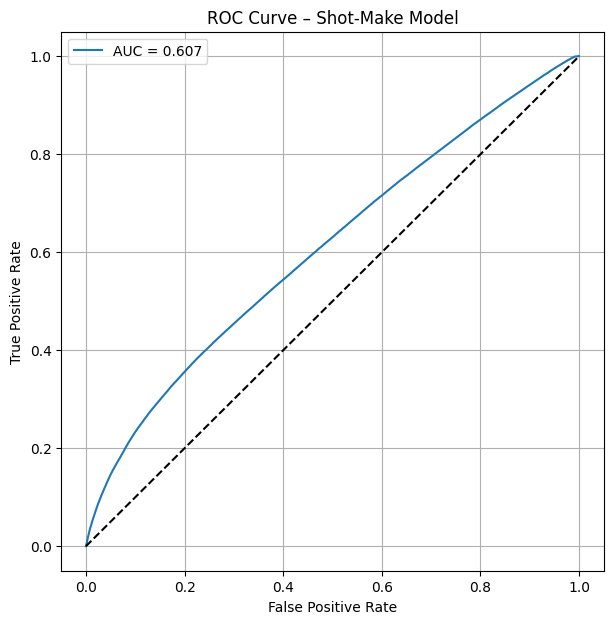

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f"AUC = {roc_val:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


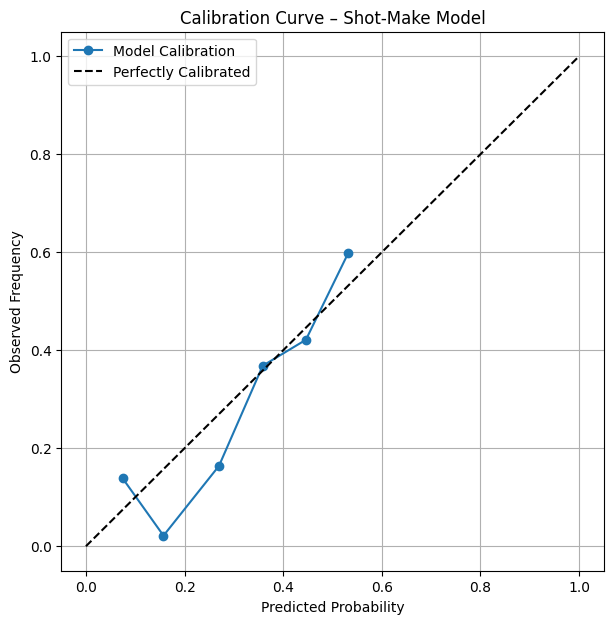

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0,1],[0,1],'k--', label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm


In [ ]:
class ShotDataset(Dataset):
    def __init__(self, shooter_ids, numeric_feats, labels):
        self.shooter_ids = torch.tensor(shooter_ids, dtype=torch.long)
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.shooter_ids[idx], self.numeric_feats[idx], self.labels[idx]


In [ ]:
class ShotMakeMLP(nn.Module):
    def __init__(self, num_shooters, embed_dim, num_numeric_feats, hidden_dims=[64,32]):
        super().__init__()
        self.embedding = nn.Embedding(num_shooters, embed_dim)
        input_dim = embed_dim + num_numeric_feats
        
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(0.2))
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))  # single output for logistic
        self.mlp = nn.Sequential(*layers)

    def forward(self, shooter_id, numeric_feats):
        x_embed = self.embedding(shooter_id)
        x = torch.cat([x_embed, numeric_feats], dim=1)
        x = self.mlp(x)
        return torch.sigmoid(x).squeeze()


In [ ]:
# Sort shots by shooter and possession_id
model_df = model_df.sort_values(["shooter", "possession_id"])

# Rolling 5-shot success rate
model_df["shooter_last5_fg"] = (
    model_df.groupby("shooter")["event_class"]
            .apply(lambda x: x.eq("shot_make").rolling(5, min_periods=1).mean())
)


TypeError: incompatible index of inserted column with frame index

In [ ]:
# Example: only numeric feature is shot_distance
numeric_features = model_df[["shot_distance"]].values.astype(np.float32)
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

# Map shooters to integer IDs
shooter2id = {name:i for i,name in enumerate(model_df["shooter"].unique())}
shooter_ids = model_df["shooter"].map(shooter2id).values

# Labels
labels = model_df["is_make"].values.astype(np.float32)

# Train / validation / test split
X_train_ids, X_test_ids, X_train_num, X_test_num, y_train, y_test = train_test_split(
    shooter_ids, numeric_features, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train_ids, X_val_ids, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_train_ids, X_train_num, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [ ]:
batch_size = 1024

train_dataset = ShotDataset(X_train_ids, X_train_num, y_train)
val_dataset = ShotDataset(X_val_ids, X_val_num, y_val)
test_dataset = ShotDataset(X_test_ids, X_test_num, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ShotMakeMLP(
    num_shooters=len(shooter2id),
    embed_dim=16,
    num_numeric_feats=X_train_num.shape[1],
    hidden_dims=[64,32]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

best_val_loss = float("inf")
patience = 5
patience_counter = 0
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for shooter_batch, num_batch, label_batch in train_loader:
        shooter_batch = shooter_batch.to(device)
        num_batch = num_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        pred = model(shooter_batch, num_batch)
        loss = criterion(pred, label_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(label_batch)

    train_loss /= len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for shooter_batch, num_batch, label_batch in val_loader:
            shooter_batch = shooter_batch.to(device)
            num_batch = num_batch.to(device)
            label_batch = label_batch.to(device)
            pred = model(shooter_batch, num_batch)
            loss = criterion(pred, label_batch)
            val_loss += loss.item() * len(label_batch)
    val_loss /= len(val_dataset)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

model.load_state_dict(best_weights)


Epoch 1 - Train Loss: 0.6656 - Val Loss: 0.6603
Epoch 2 - Train Loss: 0.6607 - Val Loss: 0.6594
Epoch 3 - Train Loss: 0.6598 - Val Loss: 0.6594
Epoch 4 - Train Loss: 0.6593 - Val Loss: 0.6589
Epoch 5 - Train Loss: 0.6589 - Val Loss: 0.6584
Epoch 6 - Train Loss: 0.6586 - Val Loss: 0.6582
Epoch 7 - Train Loss: 0.6582 - Val Loss: 0.6584
Epoch 8 - Train Loss: 0.6581 - Val Loss: 0.6579
Epoch 9 - Train Loss: 0.6579 - Val Loss: 0.6579
Epoch 10 - Train Loss: 0.6577 - Val Loss: 0.6578
Epoch 11 - Train Loss: 0.6576 - Val Loss: 0.6579
Epoch 12 - Train Loss: 0.6575 - Val Loss: 0.6577
Epoch 13 - Train Loss: 0.6574 - Val Loss: 0.6577
Epoch 14 - Train Loss: 0.6572 - Val Loss: 0.6579
Epoch 15 - Train Loss: 0.6572 - Val Loss: 0.6576
Epoch 16 - Train Loss: 0.6572 - Val Loss: 0.6575
Epoch 17 - Train Loss: 0.6570 - Val Loss: 0.6576
Epoch 18 - Train Loss: 0.6570 - Val Loss: 0.6575
Epoch 19 - Train Loss: 0.6568 - Val Loss: 0.6576
Epoch 20 - Train Loss: 0.6569 - Val Loss: 0.6575
Epoch 21 - Train Loss: 0.6568

<All keys matched successfully>

In [ ]:
model.eval()
proba_test = []

with torch.no_grad():
    for shooter_batch, num_batch, _ in test_loader:
        shooter_batch = shooter_batch.to(device)
        num_batch = num_batch.to(device)
        pred = model(shooter_batch, num_batch)
        proba_test.append(pred.cpu().numpy())

proba_test = np.concatenate(proba_test)
y_pred_test = (proba_test >= 0.5).astype(int)


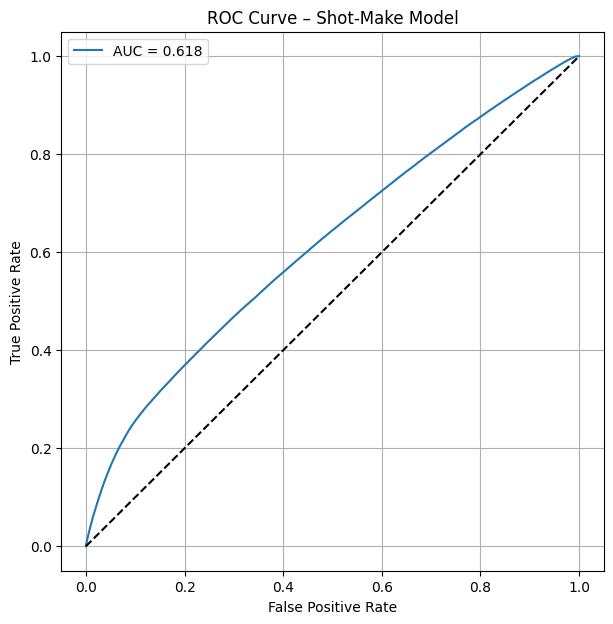

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f"AUC = {roc_val:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


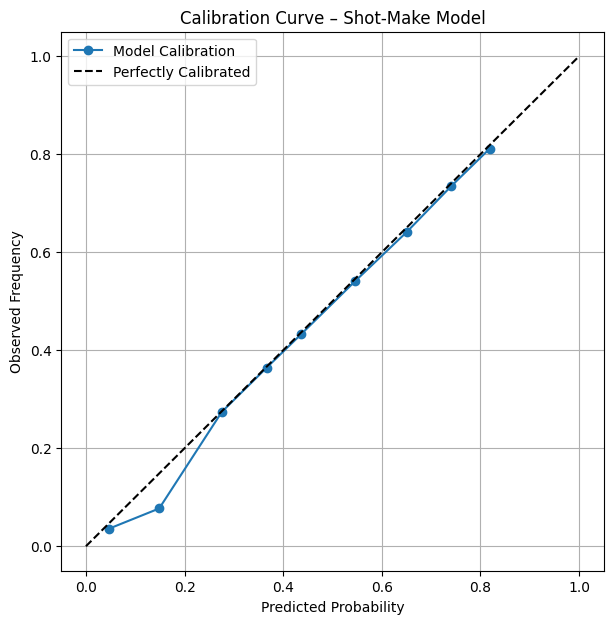

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0,1],[0,1],'k--', label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve – Shot-Make Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# y_test should be a NumPy array of true labels
# If it's still a torch tensor, convert: y_test_np = y_test.cpu().numpy()
y_test_np = np.array(y_test)  # or y_test.values if it's a pandas Series

# Accuracy
acc = accuracy_score(y_test_np, y_pred_test)

# AUC (from probabilities)
auc_val = roc_auc_score(y_test_np, proba_test)

print(f"Test Accuracy: {acc:.3f}")
print(f"Test AUC: {auc_val:.3f}")


Test Accuracy: 0.618
Test AUC: 0.618
